## data pre from day15

In [ ]:
import os

data_dir ='/home/wufisher/dataset_m/jena_climate'
fname= os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
import numpy as np


float_data = np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

mean= float_data[:200000].mean(axis=0)
float_data-=mean
std =  float_data[:200000].std(axis=0)
float_data/=std

def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_sice=128,step=6):
    if max_index is None:
        max_index = len(data)-delay-1
    i = min_index+lookback
    while 1 :
        if shuffle:
            rows = np.random.randint(
                min_index+lookback,max_index,size=batch_sice
            )
        else :
            if i+batch_sice>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_sice,max_index))
            i+=len(rows)

        samples = np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j , row in enumerate(rows):
            indices = range(rows[j]-lookback,rows[j],step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples , targets

lookback  = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=200000,
shuffle=True,
step=step,
batch_sice=batch_size)

val_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=200001,
max_index=300000,
step=step,
batch_sice=batch_size)

test_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=300001,
max_index=None,
step=step,
batch_sice=batch_size)

# 得到验证和测试需要抽取多少次

val_steps = (300000-200001-lookback)//batch_size
test_steps = (len(float_data)-300001-lookback)//batch_size

## 使用dropout层来降低过拟合

    一般来说循环层面前，使用dropout会阻碍学习过程
    但是这里我们对与每一个时间步采用相同的dropout掩码，能够正确的传播其学习误差，如果dorpout码随时间变化，则会破坏这个误差信号
    这里我们采用参数内置 
                    dropout：指定输入单元层dropout层比率
                    recurrent_dropout循环单元层的比率
                    !!!更新之后，别用recurrent_dropout参数，会训练的非常垃圾
    值得注意的是需要花费更多的时间，所以这里我们的训练轮次增加为原来的两倍

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2
model = Sequential()
model.add(layers.GRU(32,dropout=0.2,input_shape=(None,float_data.shape[-1])))
#最后一层使用线性激活函数
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mae')
history = model.fit(
    train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps
)

Epoch 1/40
500/500 [==============================] - 16s 30ms/step - loss: 0.3233 - val_loss: 0.2823
Epoch 2/40
500/500 [==============================] - 14s 29ms/step - loss: 0.3040 - val_loss: 0.2746
Epoch 3/40
500/500 [==============================] - 15s 29ms/step - loss: 0.2968 - val_loss: 0.2717
Epoch 4/40
500/500 [==============================] - 15s 31ms/step - loss: 0.2912 - val_loss: 0.2746
Epoch 5/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2862 - val_loss: 0.2774
Epoch 6/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2820 - val_loss: 0.2770
Epoch 7/40
500/500 [==============================] - 16s 31ms/step - loss: 0.2772 - val_loss: 0.2792
Epoch 8/40
500/500 [==============================] - 16s 31ms/step - loss: 0.2732 - val_loss: 0.2778
Epoch 9/40
500/500 [==============================] - 16s 31ms/step - loss: 0.2701 - val_loss: 0.2753
Epoch 10/40
500/500 [==============================] - 16s 31ms/step - loss: 0.266

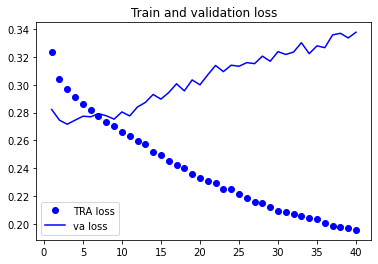

In [9]:
from matplotlib import pyplot as plt
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='TRA loss')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('GRU_drop_v2_loss.png')
plt.show()

测试以下时间，感觉dropout层花费时间好久

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2
model = Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
#最后一层使用线性激活函数
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mae')
history = model.fit(
    train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps
)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2
model = Sequential()
model.add(layers.GRU(32,dropout=0.1,return_sequences=True,input_shape=(None,float_data.shape[-1])))

model.add(layers.GRU(64,dropout=0.1,activation='relu'))
# 最后一层使用线性激活函数
model.add(layers.Dense(1))

model.compile(optimizer=rmsprop_v2.RMSProp(),loss='mae')
history = model.fit(
    train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps
)

加了一层之后其实效果并没有好多少，可以看出循环网络层的效果是在减弱的

## 双向序列处理
    通过bidirectional层，相当于把所有的序列正着输入进去一次，倒着在输入进去一次
    对于语句训练而言，效果有略微的提升，原因在于我们阅读的时候顺序并没有那么重要
    但是对于天气对于时间要求非常高的，逆序的数据输入进去得到的效果将会非常的差（这里就不写出来了）

双向LSTM

In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)
x_train = [x[::-1]for x in x_train]
x_test  =[x[::-1]for x in x_test]

x_train = sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = sequence.pad_sequences(x_test,maxlen=maxlen)
# x中的序列为一句话每个单词代表的索引，所以只用逆序x不用y，相当于把一句话反着来说

In [5]:
model=Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history= model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)



Epoch 1/10
157/157 [==============================] - 10s 45ms/step - loss: 0.5835 - acc: 0.6962 - val_loss: 0.4541 - val_acc: 0.8272
Epoch 2/10
157/157 [==============================] - 7s 45ms/step - loss: 0.3591 - acc: 0.8571 - val_loss: 0.4195 - val_acc: 0.8070
Epoch 3/10
157/157 [==============================] - 7s 46ms/step - loss: 0.2784 - acc: 0.8964 - val_loss: 0.3346 - val_acc: 0.8664
Epoch 4/10
157/157 [==============================] - 7s 42ms/step - loss: 0.2400 - acc: 0.9109 - val_loss: 0.3696 - val_acc: 0.8608
Epoch 5/10
157/157 [==============================] - 7s 44ms/step - loss: 0.2143 - acc: 0.9239 - val_loss: 0.3107 - val_acc: 0.8782
Epoch 6/10
157/157 [==============================] - 7s 42ms/step - loss: 0.1896 - acc: 0.9345 - val_loss: 0.3676 - val_acc: 0.8778
Epoch 7/10
157/157 [==============================] - 8s 48ms/step - loss: 0.1711 - acc: 0.9399 - val_loss: 0.3484 - val_acc: 0.8732
Epoch 8/10
157/157 [==============================] - 7s 45ms/step -

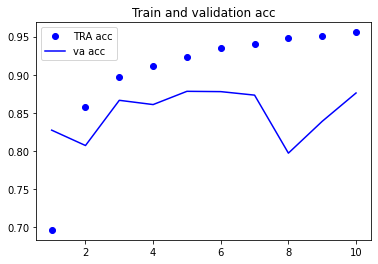

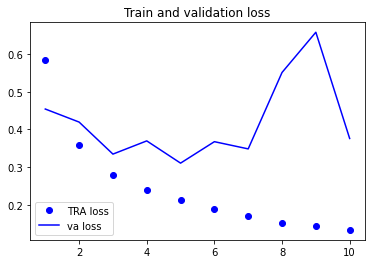

In [6]:
from matplotlib import pyplot as plt
acc= history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'bo',label='TRA acc')
plt.plot(epochs,val_acc,'b',label='va acc')
plt.title('Train and validation acc')
plt.legend()
plt.savefig('IMDB_biLSTM_v2_acc.png')
plt.show()
plt.figure()
plt.plot(epochs,loss,'bo',label='TRA loss')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('GIMDB_biLSTM_v2_loss.png')
plt.show()